In [1]:
import polars as pl
import matplotlib.pyplot as plt
import blitzbeaver as bb

pl.Config.set_tbl_rows(100)

polars.config.Config

In [2]:
def preprocess_df(df: pl.DataFrame) -> pl.DataFrame:
    # we need to cap the string values to a maximum of 256 characters
    # to avoid issues in the computation of the levenshtein distance
    return df.with_columns(
        df["enfants_chez_parents_prenom"]
        .str.split("|")
        .list.eval(pl.element().filter(pl.element() != "").slice(0, 255))
        .alias("enfants_chez_parents_prenom"),
        df["nom_rue"].str.slice(0, 255).alias("nom_rue"),
        df["chef_prenom"].str.slice(0, 255).alias("chef_prenom"),
        df["chef_nom"].str.slice(0, 255).alias("chef_nom"),
        df["chef_origine"].str.slice(0, 255).alias("chef_origine"),
        df["epouse_nom"].str.slice(0, 255).alias("epouse_nom"),
        df["chef_vocation"].str.slice(0, 255).alias("chef_vocation"),
    )

def postprocess_df(df: pl.DataFrame) -> pl.DataFrame:
    return df.with_columns(
        df["enfants_chez_parents_prenom"].list.join("|").alias("enfants_chez_parents_prenom"),
    )

In [3]:
csv_path = "../../aptihramy/data/csv_cleaned"

start_year = 1885
end_year = 1898

dataframes = []
for year in range(start_year, end_year + 1):
    df = pl.read_csv(f"{csv_path}/{year}.csv", infer_schema_length=10000)
    dataframes.append(preprocess_df(df))    

In [15]:
# load the graph from a .beaver file
path_graph = "../graph.beaver"

graph = bb.read_beaver(path_graph)

In [4]:
record_schema = bb.RecordSchema(
    [
        bb.FieldSchema("nom_rue", bb.ElementType.String),
        bb.FieldSchema("chef_prenom", bb.ElementType.String),
        bb.FieldSchema("chef_nom", bb.ElementType.String),
        bb.FieldSchema("chef_origine", bb.ElementType.String),
        bb.FieldSchema("epouse_nom", bb.ElementType.String),
        bb.FieldSchema("chef_vocation", bb.ElementType.String),
        bb.FieldSchema("enfants_chez_parents_prenom", bb.ElementType.MultiStrings),
    ]
)

In [5]:
distance_metric_config = bb.DistanceMetricConfig(
    metric="lv_opti",
    caching_threshold=4,
    use_sigmoid=False,
    lv_substring_weight=0.5,
)
normal_memory_config = bb.MemoryConfig(
    memory_strategy="median",
)
multi_memory_config = bb.MemoryConfig(
    memory_strategy="mw-median",
    multiword_threshold_match=0.6,
    multiword_distance_metric=distance_metric_config,
)

config = bb.config(
    record_schema=record_schema,
    distance_metric_config=distance_metric_config,
    record_scorer_config=bb.RecordScorerConfig(
        record_scorer="average",
        weights=None,
        min_weight_ratio=None
    ),
    resolver_config=bb.ResolverConfig(
        resolving_strategy="best-match",
    ),
    memory_config=normal_memory_config,
    multistring_memory_config=multi_memory_config,
    interest_threshold=0.6,
    limit_no_match_streak=3,
    num_threads=10,
)

In [6]:
config = bb.deserialize_tracking_config(
    {
        "num_threads": 17,
        "tracker": {
            "interest_threshold": 0.79,
            "limit_no_match_streak": 4,
            "record_scorer": {
                "record_scorer": "weighted-average",
                "weights": [
                    0.15,
                    0.20,
                    0.30,
                    0.15,
                    0.15,
                    0.15,
                    0.15,
                ],
                "min_weight_ratio": 0.7,
            },
            "memories": [
                {
                    "memory_strategy": "ls-median",
                    "multiword_threshold_match": None,
                    "multiword_distance_metric": None,
                },
                {
                    "memory_strategy": "ls-median",
                    "multiword_threshold_match": None,
                    "multiword_distance_metric": None,
                },
                {
                    "memory_strategy": "ls-median",
                    "multiword_threshold_match": None,
                    "multiword_distance_metric": None,
                },
                {
                    "memory_strategy": "ls-median",
                    "multiword_threshold_match": None,
                    "multiword_distance_metric": None,
                },
                {
                    "memory_strategy": "ls-median",
                    "multiword_threshold_match": None,
                    "multiword_distance_metric": None,
                },
                {
                    "memory_strategy": "ls-median",
                    "multiword_threshold_match": None,
                    "multiword_distance_metric": None,
                },
                {
                    "memory_strategy": "mw-median",
                    "multiword_threshold_match": 0.8,
                    "multiword_distance_metric": {
                        "metric": "lv_substring",
                        "caching_threshold": 4,
                        "use_sigmoid": False,
                        "lv_edit_weights": None,
                        "lv_substring_weight": 0.7,
                        "lv_multiword_separator": None,
                    },
                },
            ],
        },
        "distance_metric": {
            "metric": "lv_substring",
            "caching_threshold": 4,
            "use_sigmoid": False,
            "lv_edit_weights": None,
            "lv_substring_weight": 0.7,
            "lv_multiword_separator": None,
        },
        "resolver": {"resolving_strategy": "best-match"},
    }
)

In [7]:
# compute the graph
graph = bb.execute_tracking(config, record_schema, dataframes, "debug")

[DEBUG]: processing frame 1...
[DEBUG]: [worker 2] process frame 1:  trackers: 486  cache size: 541812
[DEBUG]: [worker 7] process frame 1:  trackers: 476  cache size: 545136
[DEBUG]: [worker 13] process frame 1:  trackers: 476  cache size: 525148
[DEBUG]: [worker 4] process frame 1:  trackers: 476  cache size: 535932
[DEBUG]: [worker 15] process frame 1:  trackers: 476  cache size: 571544
[DEBUG]: [worker 17] process frame 1:  trackers: 476  cache size: 580780
[DEBUG]: [worker 6] process frame 1:  trackers: 476  cache size: 534148
[DEBUG]: [worker 12] process frame 1:  trackers: 476  cache size: 528821
[DEBUG]: [worker 9] process frame 1:  trackers: 476  cache size: 546244
[DEBUG]: [worker 14] process frame 1:  trackers: 476  cache size: 532384
[DEBUG]: [worker 5] process frame 1:  trackers: 476  cache size: 538955
[DEBUG]: [worker 3] process frame 1:  trackers: 476  cache size: 536018
[DEBUG]: [worker 8] process frame 1:  trackers: 476  cache size: 539576
[DEBUG]: [worker 11] process

16615
7840
3019
0
Number of chains: 42180
Percentage of matching records: 68.10%
Percentage of matching trackers: 83.76%
Percentage of divergences: 5.07%
Percentage of conflicts: 15.53%


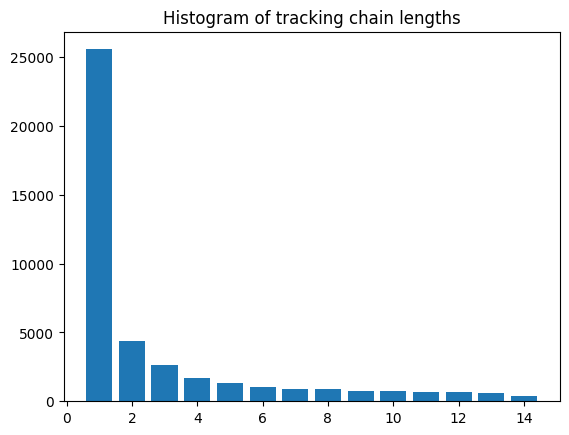

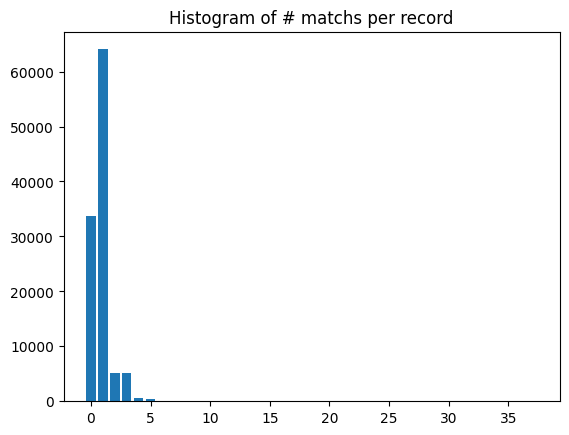

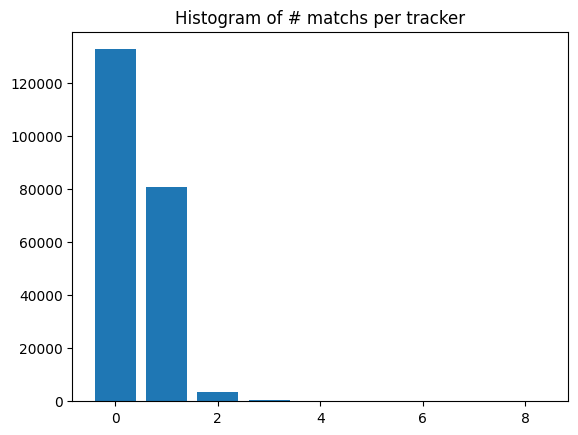

In [8]:
def aggregate_histograms(histograms: list[list[int]]) -> list[int]:
    """
    Aggregates a list of histograms into a single histogram.
    """
    max_len = max([len(h) for h in histograms])
    result = [0] * max_len
    for h in histograms:
        for i, v in enumerate(h):
            result[i] += v
    return result

def summary_graph(graph: bb.TrackingGraph):

    # compute the sum of the histograms for all frames
    histogram_records = aggregate_histograms([resolving.histogram_record_matchs for resolving in graph.diagnostics.resolvings])
    # do not show beyond 10 elements as the counts are very low
    histogram_records = histogram_records
    histogram_trackers = aggregate_histograms([resolving.histogram_tracker_matchs for resolving in graph.diagnostics.resolvings])
    histogram_trackers = histogram_trackers[:10]

    chain_metrics = bb.evaluate_tracking_chain_length(graph._raw)
    graph_metrics = bb.evaluate_tracking_graph_properties(graph._raw)
        
    records_match_ratios = graph_metrics.records_match_ratios[1:]
    trackers_match_ratios = graph_metrics.trackers_match_ratios[1:-1]
    avg_records_match = sum(records_match_ratios) / len(records_match_ratios)
    avg_trackers_match = sum(trackers_match_ratios) / len(trackers_match_ratios)

    per_divergence = sum(histogram_trackers[2:]) / sum(histogram_trackers[1:])
    per_conflict = sum(histogram_records[2:]) / sum(histogram_records[1:])

    print(sum(chain_metrics.histogram[2:]))
    print(sum(chain_metrics.histogram[5:]))
    print(sum(chain_metrics.histogram[10:]))
    print(sum(chain_metrics.histogram[20:]))

    # total number of trackers created
    print(f"Number of chains: {len(graph.trackers_ids)}")
    # average percentage of records that have been match with an existing tracker
    print(f"Percentage of matching records: {avg_records_match*100:.2f}%")
    # average percentage of trackers that have match with a record of the current frame
    print(f"Percentage of matching trackers: {avg_trackers_match*100:.2f}%")
    # number of times a tracker matched with more that one record
    # divided by the number of times a tracker matched with a record
    print(f"Percentage of divergences: {per_divergence*100:.2f}%")
    # number of times a record matched with multiple trackers
    # divided by the number of times a record matched with a tracker
    print(f"Percentage of conflicts: {per_conflict*100:.2f}%")

    plt.bar(range(1, len(chain_metrics.histogram)), chain_metrics.histogram[1:])
    plt.title("Histogram of tracking chain lengths")
    plt.show()

    plt.bar(range(len(histogram_records)), histogram_records)
    plt.title("Histogram of # matchs per record")
    plt.show()

    plt.bar(range(len(histogram_trackers)), histogram_trackers)
    plt.title("Histogram of # matchs per tracker")
    plt.show()
    
summary_graph(graph)

In [12]:
path_graph = "../graph.beaver"

bb.save_beaver(path_graph, graph)

In [ ]:
normalization_config = bb.NormalizationConfig(
    threshold_cluster_match=0.5,
    min_cluster_size=2,
    distance_metric=config.distance_metric,
)

In [ ]:
normalized_dfs = bb.execute_normalization(
    normalization_config,
    record_schema,
    graph,
    dataframes,
)

In [ ]:
normalized_csv_path = "/home/plouc314/Documents/epfl/ma2/shs/shs-ma1/data/normalized"

start_year = 1835
end_year = 1892

for year, df in zip(range(start_year, end_year + 1), normalized_dfs):
    df = postprocess_df(df)
    df.write_csv(f"{normalized_csv_path}/{year}.csv", include_header=True)

In [ ]:
def find_chain_with_length(graph: bb.TrackingGraph, start_idx: int, length: int) -> None:
    idx = start_idx
    while idx < len(graph.trackers_ids):
        tracker_id = graph.trackers_ids[idx]
        chain = graph._raw.get_tracking_chain(tracker_id)
        if len(chain) >= length:
            return tracker_id
        idx += 1
    return None

In [ ]:
# chain = find_chain_with_length(graph, dataframes, record_schema, 0, 3)
tracker_id = find_chain_with_length(graph, 2000, 20)
chain = graph.materialize_tracking_chain(tracker_id, dataframes, record_schema, normalized_dfs)
chain.as_dataframe()

In [ ]:
chain.as_dataframe(normalized=True)

In [ ]:
df = chain.as_dataframe()

In [ ]:
def get_col_as_list(df: pl.DataFrame, col: str) -> list[str]:
    return [v for v in df[col] if v is not None]

In [ ]:
words = [
    "magimelien",
    "mazimilien",
    "mazirelien",
    "marinelien",
    "hgdfzs",
    "bob",
    "boob",
]
bb.compute_median_word(words)


In [ ]:
bb.compute_words_clusters(
    words,
    distance_metric_config,
    threshold_match=0.6,
)

In [ ]:
bb.normalize_words(
    get_col_as_list(df, "nom_rue"),
    distance_metric_config,
    threshold_match=0.6,
    min_cluster_size=2,
)